## China - US Trade Decoupling

Sources:

https://www.federalreserve.gov/econres/notes/feds-notes/did-the-us-bilateral-goods-deficit-with-china-increase-or-decrease-during-the-us-china-trade-conflict-20210621.html

https://www.census.gov/foreign-trade/balance/c5700.html

https://www.bea.gov/sites/default/files/2023-12/trad-geo-time-series-1023.xlsx

http://english.customs.gov.cn/Statistics/Statistics?ColumnId=1

https://twitter.com/Brad_Setser/status/1732932408029098378





In [1]:
# Import libraries / preliminaries
%config Completer.use_jedi = False
import pandas as pd
import requests
import io, itertools, time, os
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
plt.rc('axes', edgecolor='lightgray')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=9)

data_dir = Path('/home/brian/Documents/uschartbook/chartbook/data/')

# Recession start and end months, from NBER
rec_dt = [('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]

# Seasonal Adjustment Tools
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'
import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_analysis

# Function to retrieve a series from FRED
def fred_df(series):
    url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
    df = pd.read_csv(url, index_col='DATE', parse_dates=True, na_values=['.'])
    return df.rename({'VALUE': series}, axis=1)

### US Reported Trade Data

In [2]:
# GDP Monthly including latest Nowcast
pce = pd.read_csv(data_dir / 'pce_now.csv', index_col='date', parse_dates=True)
gdp = fred_df('GDP')['GDP']
now = fred_df('GDPNOW')['GDPNOW']
nch = pd.concat([pce, now],axis=1).iloc[-1].sum()
nqch = (((nch / 100) + 1) ** (1/4))
gdp.loc[now.index[-1]] = gdp.iloc[-1] * nqch
gdpmo = gdp.resample('MS').interpolate().shift(2) * 1_000
gdpmo.index = gdpmo.index + pd.DateOffset(months=2)

In [3]:
# BEA Data
# bea = pd.read_excel('trad-geo-time-series-1023.xlsx', 
#                     sheet_name='Table 5', header=5, index_col=0)
# bea_ch = (bea.iloc[26:-8]['China'] * 4) / 1_000
# bea_ch.index = (bea_ch.index.str.replace('(R)', '', regex=False)
#                       .str.rstrip().str.replace(' ', 'Q'))
# bea_ch.index = pd.to_datetime(bea_ch.index)
# beag = bea_ch.divide(gdp).dropna() * 100
# beag = beag.resample('MS').interpolate()
# beag.index = beag.index + pd.DateOffset(months=2)

In [4]:
# Census Data
# Retrieve trade data
url = ('https://www.census.gov/foreign-trade/balance/country.xlsx')
droplist = ['CTY_CODE', 'CTYNAME', 'IYR', 'EYR']
df = (pd.read_excel(url)
        .query('CTYNAME == "China"')
        .drop(droplist, axis=1))

cen = pd.DataFrame()
for (flow, name) in [('I', 'Imports'), ('E', 'Exports')]:
    col = [i for i in df.columns if i.startswith(flow)]
    dft = df.melt(id_vars=['year'], value_vars=col, 
                  var_name='Month', value_name=name)
    dft['date'] = pd.to_datetime(dft.Month.str[1:] + ' ' + 
                                 dft.year.astype('str'))
    s = (dft.loc[dft[name] > 0]
            .set_index('date')[name].sort_index()) * 12
    cen[name] = s
    cen[f'{name}_SA'] = x13_arima_analysis(s).seasadj
    
cen['Balance'] =  cen['Exports'] - cen['Imports']
cen['Balance_SA'] =  cen['Exports_SA'] - cen['Imports_SA']

cen3g = (cen.rolling(3).mean().dropna()
            .divide(gdpmo, axis=0).dropna() * 100)
cen3gs = cen3g[[i for i in cen3g.columns if i.endswith('SA')]]

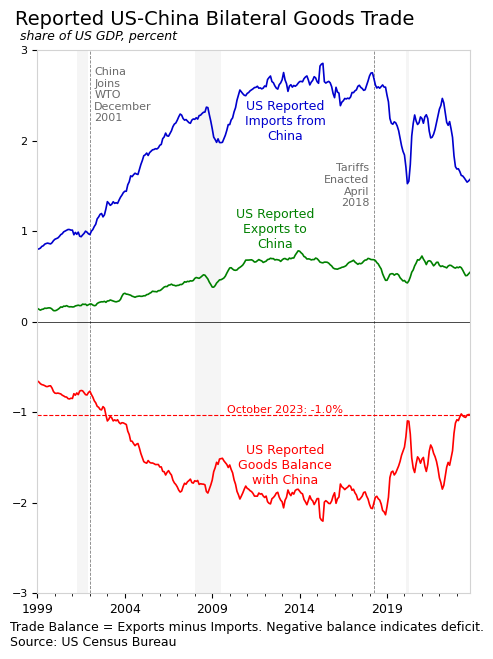

In [5]:
# Chart 1 - US Reported Data
fig, ax = plt.subplots(figsize=(5, 6))
plt.tight_layout()
colors = ['mediumblue', 'green', 'red']
#beag.plot(ax=ax, color=colors[1], lw=2.2)
(cen3gs.loc['1999':].dropna().plot(ax=ax, color=colors, lw=1.2, legend=False))

# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)

# Title and footer
fig.text(0.04, 1.01, 'Reported US-China Bilateral Goods Trade', size=14)
subtitle = ('share of US GDP, percent')
fig.text(0.05, 0.985, subtitle, size=9, style='italic')
footer = ('Trade Balance = Exports minus Imports. Negative balance '+
          'indicates deficit.\nSource: US Census Bureau')
fig.text(0.03, -0.025, footer, size=9)

ax.set_ylim(-3, 3)

plt.axvline('2018-04-01', zorder=0, lw=0.6, color='gray', ls='--')
ax.text('2018-01-01', 1.5, 'Tariffs\nEnacted\nApril\n2018', color='dimgray', size=8, 
        va='center', ha='right')
plt.axvline('2002-01-01', zorder=0, lw=0.6, color='gray', ls='--')
ax.text('2002-04-01', 2.5, 'China\nJoins\nWTO\nDecember\n2001', color='dimgray', size=8, 
        va='center', ha='left')
plt.axhline(0, zorder=0, lw=0.5, color='black')

usitxt = 'US Reported\nImports from\nChina'
ax.text('2013-03-01', 2.45, usitxt, color=colors[0], size=9, 
        va='top', ha='center')
usetxt = 'US Reported\nExports to\nChina'
ax.text('2012-08-01', 1.25, usetxt, color=colors[1], size=9, 
        va='top', ha='center')
usbtxt = 'US Reported\nGoods Balance\nwith China'
ax.text('2013-03-01', -1.35, usbtxt, color=colors[2], size=9, 
        va='top', ha='center')
balvallt = cen3gs['Balance_SA'].iloc[-1]
plt.axhline(balvallt, zorder=0, lw=0.8, 
            color=colors[2], ls='--')
lttxt = f'{cen3gs.index[-1].strftime("%B %Y")}: {balvallt:.1f}%'
ax.text('2013-03-01', balvallt, lttxt, color=colors[2], size=8, 
        va='bottom', ha='center')

# legend
#ax.legend(edgecolor='lightgray', bbox_to_anchor=(0, 1), 
#              loc='upper left', fontsize=9)

plt.savefig('chart1.png', bbox_inches='tight')
plt.show()

### China Reported Trade Data

In [6]:
# China Customs data
data2 = pd.concat([pd.read_csv(f'downloadDataEX({i}).csv', 
                       index_col='Date of data', 
                       parse_dates=True) 
           for i in range(1, 10)])['US dollar']
data2.index = [pd.to_datetime(f'{i[:4]}-{i[4:]}-01') 
               for i in data2.index.astype('str')]
data2 = data2.sort_index().str.replace(',', '').astype('float') / 1_000_000
data2.name = 'China Reported'
data2.loc['2023-11-01'] = 43803.4 # From preliminary report
sa2 = x13_arima_analysis(data2).seasadj
sag3ch = ((sa2*12)/gdpmo).dropna().rolling(3).mean() * 100

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [7]:
# Project US Reported data with pre-tariff gap
us_adj = (sag3ch.loc['2018-04-01':] + 
          cen3gs['Imports_SA'].subtract(sag3ch).loc['2015-04-01':'2018-01-01'].mean())

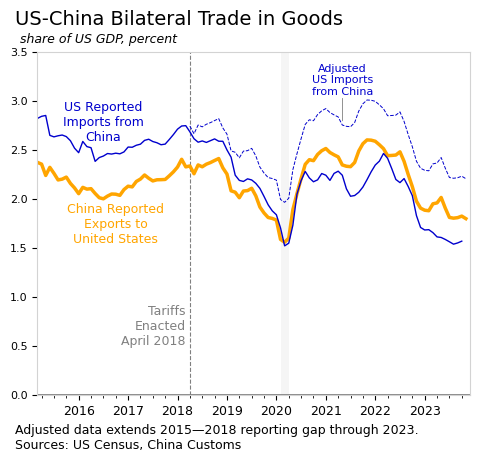

In [8]:
# Create Chart 2
#data = pd.concat([data1.loc['2015':], data2], axis=1)
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
colors = ['mediumblue', 'orange']
sag3ch.plot(ax=ax, color=colors[1], lw=2.5)
cen3gs.loc['2015':, 'Imports_SA'].plot(ax=ax, color=colors[0], lw=1.0)
us_adj.plot(ax=ax, color=colors[0], ls='--', lw=0.7)

# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)

# Title and footer
fig.text(0.04, 1.02, 'US-China Bilateral Trade in Goods', size=14)
subtitle = ('share of US GDP, percent')
fig.text(0.05, 0.975, subtitle, size=9, style='italic')
footer = ('Adjusted data extends 2015—2018 reporting gap through 2023.\n'+
          'Sources: US Census, China Customs')
fig.text(0.04, -0.04, footer, size=9)

# Annotations
ustxt = 'US Reported\nImports from\nChina'
ax.text('2016-07-01', 3.0, ustxt, color=colors[0], size=9, 
        va='top', ha='center')
adjtxt = 'Adjusted\nUS Imports\nfrom China'
ax.text('2021-05-01', 3.38, adjtxt, color=colors[0], size=8, 
        va='top', ha='center')
plt.arrow('2021-05-01',3.03,0,-0.23, lw=0.3, color='gray')
chtxt = 'China Reported\nExports to\nUnited States'
ax.text('2016-10-01', 1.96, chtxt, color=colors[1], size=9, 
        va='top', ha='center')

ax.set_ylim(0, 3.5)
ax.set_xlim('2015-03-01', '2023-12-01')

plt.axvline('2018-04-01', zorder=0, lw=0.8, color='gray', ls='--')
ax.text('2018-03-01', 0.7, 'Tariffs\nEnacted\nApril 2018', color='gray', size=9, 
        va='center', ha='right')
plt.axhline(0, zorder=0, lw=2, color='gray')

plt.savefig('chart2.png', bbox_inches='tight')
plt.show()

### US Trade Balance from RoW Perspective

In [9]:
# IMF DOTS Data
url = ('http://dataservices.imf.org/REST/SDMX_JSON.svc/'+
       'CompactData/DOT/M.')
sl = ['W00+CN+CA+MX.TBG_USD.US', 'US.TBG_USD.W00+CN+CA+MX',
      'US.TMG_CIF_USD.CN', 'CN.TXG_FOB_USD.US']
# Retrieve data from IMF API
data = requests.get(f'{url}{sl[0]}').json()
df = -pd.DataFrame({s['@REF_AREA'] : {pd.to_datetime(i['@TIME_PERIOD']) : 
     round(float(i['@OBS_VALUE']), 1) for i in s['Obs']} 
     for s in data['CompactData']['DataSet']['Series']})
df.to_csv('trade_balance_with_us.csv', index_label='date')
# data = requests.get(f'{url}{sl[1]}').json()
# df = -pd.DataFrame({s['@COUNTERPART_AREA'] : {pd.to_datetime(i['@TIME_PERIOD']) : 
#      round(float(i['@OBS_VALUE']), 1) for i in s['Obs']} 
#      for s in data['CompactData']['DataSet']['Series']})
# df.to_csv('trade_balance_with_us_us_rep.csv', index_label='date')
# data = requests.get(f'{url}{sl[2]}').json()
# df = pd.DataFrame({'US_CIF_CN' : {pd.to_datetime(i['@TIME_PERIOD']) : 
#      round(float(i['@OBS_VALUE']), 1) 
#      for i in data['CompactData']['DataSet']['Series']['Obs']}})
# df.to_csv('us_cif_cn.csv', index_label='date')
# data = requests.get(f'{url}{sl[3]}').json()
# df = pd.DataFrame({'CN_FOB_US' : {pd.to_datetime(i['@TIME_PERIOD']) : 
#      round(float(i['@OBS_VALUE']), 1) 
#      for i in data['CompactData']['DataSet']['Series']['Obs']}})
# df.to_csv('cn_fob_us.csv', index_label='date')

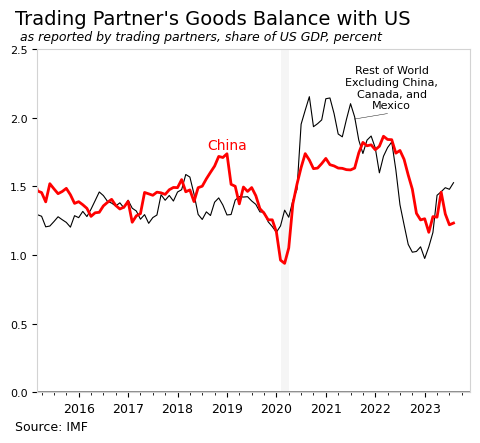

In [10]:
# Trade Balance, Partner Countries
dft = pd.read_csv('trade_balance_with_us.csv', 
                  index_col='date', parse_dates=True).sort_index()
dft['Other'] = dft['W00'] - dft[['CA', 'MX', 'CN']].sum(axis=1)
dfts2 = pd.DataFrame()
slist = ['Other', 'CN']
for s in slist:
    dfts2[s] = (x13_arima_analysis(-dft[s].loc['1999':]).seasadj
               .rolling(3).mean().dropna() * 12)

sh = dfts2.loc['2015':, ['Other', 'CN']].divide(gdpmo, axis=0).dropna() * 100

fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
colors = ['black', 'red']
sh['Other'].plot(ax=ax, color=colors[0], lw=0.8)
sh['CN'].plot(ax=ax, color=colors[1], lw=2.0)

# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)

plt.axhline(0, zorder=0, lw=2, color='gray')
adjtxt = 'Rest of World\nExcluding China,\nCanada, and\nMexico'
ax.text('2022-05-01', 2.38, adjtxt, color=colors[0], size=8, 
        va='top', ha='center')
plt.arrow('2022-04-01',2.03,-8,-0.04, lw=0.3, color='gray')
ax.text('2019-01-01', 1.85, 'China', color=colors[1], size=10, 
        va='top', ha='center')

ax.set_ylim(0, 2.5)
ax.set_xlim('2015-03-01', '2023-12-01')

# Title and footer
fig.text(0.04, 1.015, "Trading Partner's Goods Balance with US", size=14)
subtitle = ('as reported by trading partners, share of US GDP, percent')
fig.text(0.05, 0.975, subtitle, size=9, style='italic')
footer = ('Source: IMF')
fig.text(0.04, 0.0, footer, size=9)
plt.savefig('chart4.png', bbox_inches='tight')
plt.show()

In [11]:
sh.loc[:'2020-01-01', 'Other'].mean()

1.3400366225849092

### Gap in Supply and Demand during COVID

In [12]:
# Retrieve data
ipman = fred_df('IPMAN')['IPMAN']
goods = fred_df('DGDSRC1')['DGDSRC1'] * 1_000
goodssh = (goods/gdpmo).dropna() * 100

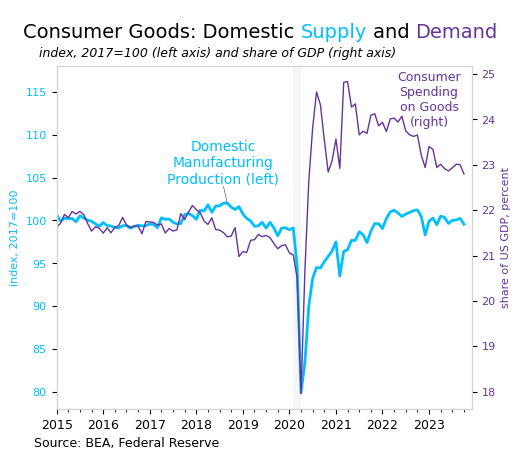

In [13]:
# Chart 4
fig, ax1 = plt.subplots(figsize=(5, 4))
ax2 = ax1.twinx()
plt.tight_layout()

colors = ['rebeccapurple', 'deepskyblue']
goodssh.index.name = ''
ipman.index.name = ''
ipman.loc['2015':].plot(ax=ax1, color=colors[1], lw=2.0, zorder=1)
goodssh.loc['2015':].plot(ax=ax2, color=colors[0], lw=1.0, zorder=2)

# Handle dual axis
ax1.set_ylabel("index, 2017=100", color=colors[1], fontsize=8)
ax1.tick_params(axis="y", labelcolor=colors[1])
ax2.set_ylabel("share of US GDP, percent", color=colors[0], fontsize=8)
ax2.tick_params(axis="y", labelcolor=colors[0])

# Recession bars
for r_start, r_end in rec_dt:
    ax1.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)

ax1.set_ylim(78, 118)
ax1.set_xlim('2015-01-01', '2023-12-01')
ax2.set_xlim('2015-01-01', '2023-12-01')
# Title and footer
subtitle = ('index, 2017=100 (left axis) and share of GDP (right axis)')
fig.text(0.05, 0.975, subtitle, size=9, style='italic')
footer = ('Source: BEA, Federal Reserve')
fig.text(0.04, 0.0, footer, size=9)

# Title
transform = ax.transAxes
labels = ['Consumer Goods: Domestic ', 'Supply', ' and ', 'Demand']
colors2 = ['black', colors[1], 'black', colors[0]]
textprops = {'size':14}
x_pos = -0.04545
for string, col in zip(labels, colors2):
    t = ax1.text(x_pos, 1.12, string, transform = transform, color = col, size = 14)

    bbox = t.get_window_extent().transformed(transform.inverted())
    x_pos = bbox.x1
    
# Label
mantxt = 'Domestic\nManufacturing\nProduction (left)'
ax1.text('2018-08-01', 104, mantxt, color=colors[1], size=10, 
        va='bottom', ha='center')
ax1.arrow('2018-08-01',104,1,-2, lw=0.3, color='gray')

pcetxt = 'Consumer\nSpending\non Goods\n(right)'
ax2.text('2023-01-01', 23.8, pcetxt, color=colors[0], size=9, 
        va='bottom', ha='center')
plt.savefig('chart3.png', bbox_inches='tight')
plt.show()